<a href="https://colab.research.google.com/github/spisupat/RL_tutorials/blob/main/Instrumental_learning_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Instrumental learning - cliff walking

In the previous tutorial, we learnt how to update predictions through time using Temporal Difference learning. In this tutorial, we will extend these ideas to actions in 3 different ways, yielding 3 different learning algorithms.
These are all "model-free" learning algorithms, since they all learn from experience directly, without an explicit model of the world - One is a policy learning method (Actor-Critic) and two are action value methods (Q-Learning and SARSA)

Let us first setup a 12x4 grid-world environment where we will be **cliff-walking** - a star represents your current position, a black bar represents a cliff that you could fall off (reward of -100 & reset to starting position), and a white square represents your goal (reward of +100). Until you reach the goal, every movement you make is costly (reward of -1), so in order to minimize cost, you should reach the goal as quickly as possible, without falling off the cliff.


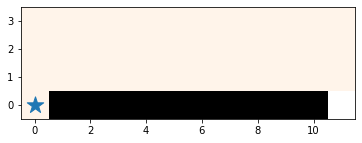

In [1]:
# ***NOTE*** 
# This notebook uses some object-oriented programming to make moving around the world & plotting easier. 
# Don't worry too much if you are not familiar with objects, they simply serve as self-contained functions that you can interact with.

# Importing some basic libraries we will use
import numpy as np                        # Mathematical library with support for matrix manipulation akin to MATLAB
import matplotlib.pyplot as plt           # Plotting library similar to MATLAB's "plot"
from IPython.display import clear_output  #Useful to animate plots

# This class helps us create a "gridworld" object that responds to your actions by updating your position & giving you rewards
# For e.g. env = gridworld() creates an object called "env" whose functions can be invoked e.g. by env.move(action)
# Instances of the object "env" itself are referred to as "self" within function definitions
class gridworld:

  # Initialization 
  def __init__(self):
    self.S = [0,0]            # Starting position 'S' in the gridworld
    self.R = -np.ones([12,4]) # Cost of -1 everytime you move in the 12x4 grid
    self.R[1:11,0] = -100     # Cost of -100 if you fall off the cliff   
    self.R[11,0] = 100          # Reward of 1 if you reach the goal

  # Plot gridworld & current position
  def plot(self,ax):
    ax.imshow(self.R.T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
    ax.invert_yaxis()
    ax.scatter(self.S[0],self.S[1],300,marker='*')

  # Move based on action inputs
  def move(self, action):
    # Previous position 'Sprev'
    Sprev = self.S
    # Try moving to new position 'Scurr'
    if action == 0:    
      Scurr = [self.S[0]-1,self.S[1]]     # left
    elif action == 1:  
      Scurr = [self.S[0]+1,self.S[1]]     # right
    elif action == 2:  
      Scurr = [self.S[0],self.S[1]-1]     # down
    elif action == 3:  
      Scurr = [self.S[0],self.S[1]+1]     # up  

    # Reset to start if you fall off the cliff
    if Scurr[0]>0 and Scurr[0]<11 and Scurr[1]==0:
      Rcurr = -100
      Scurr = [0,0]
    # Reset to start if you reach the goal
    elif Scurr[0]==11 and Scurr[1]==0:
      Rcurr = 100
      Scurr = [0,0]
    # No movement, cost of -5 if you hit a wall
    elif Scurr[0]<0 or Scurr[0]>11 or Scurr[1]<0 or Scurr[1]>3:
      Scurr = Sprev
      Rcurr = -5
    # Any other movement costs -1
    else:
      Rcurr = -1

    # Final new position 'Scurr'
    self.S = Scurr

    # Return old, new positions & reward at new position
    return Sprev, Scurr, Rcurr

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
env = gridworld()
env.plot(ax)
plt.show()

Here's a short simulation of an agent wandering around randomly in the gridworld. Notice how it falls off the cliff occasionally! 

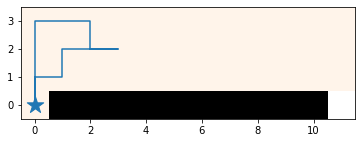

In [2]:
# Wander around randomly in gridworld
env = gridworld()
i0 = 0         
nTimesteps = 100                       # Number of timesteps
Shistory = np.zeros([2,nTimesteps+1])  # History of positions
Shistory[:,i0] = env.S                 # Initial position

for i in np.arange(1, nTimesteps):
  clear_output(wait=True)
  # Move randomly - Possible actions are 0(left), 1(right), 2(down), 3(up)
  Sprev, Scurr, Rcurr = env.move(np.random.choice([0,1,2,3]))
  # Plot new position
  fig = plt.figure(figsize=(6, 4))
  ax = fig.add_subplot(111)
  env.plot(ax)
  # Save new position
  Shistory[:,i] = Scurr
  # Plot most recent trajectory
  plt.plot(Shistory[0,i0:i+1],Shistory[1,i0:i+1])
  if Scurr == [0,0]:
    i0 = i
  plt.show()

## 1. Actor-critic learning
As you can see, we need to improve our policy if we want to ever reach the goal! The first algorithm we will use is actor-critic, which calculates **temporal-difference** prediction errors based on state values using a familiar equation, and uses the same prediction error to update both the value function  of the **critic** $V(S_t)$ with a learning rate $\eta_v$,  and the policy parameter of the action performed by the **actor** $\theta (a_t,S_t)$, with a learning rate $\eta_p$

$$ \delta_{t+1} = r(S_{t+1}) + V(S_{t+1}) - V(S_{t})\\
V(S_{t})^{new} \leftarrow V(S_t) + \eta_v \delta_{t+1}\\
\theta (a_t, S_{t})^{new} \leftarrow \theta (a_t, S_t) + \eta_p \delta_{t+1}
$$

The policy parameters $\theta$ are often called the action  *propensities* or action *preferences* and directly determine the policy through the following transformation, making it a **policy learning** algorithm:

$$ p(a_t | S_t) = \frac{e^{\theta(a_t,S_t)}}{\sum_j{e^{\theta(a_j,S_t)}}}
$$



 ## Question 1
The code below calculates a TD error and updates the state value function in the same way as the TD-learning tutorial. Add a line to update the policy parameters using this same TD error

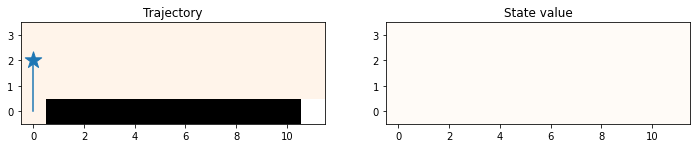

In [3]:
# Setup environment
env = gridworld()                      
i0 = 0         
nTimestepsTrain = 5000                 # Number of timesteps
nTimestepsTest = 50                    # Number of timesteps
Shistory = np.zeros([2,nTimesteps+1])  # History of positions
Shistory[:,i0] = env.S                 # Initial position

# Actor-critic learning variables
V = np.zeros([12,4])         # Array of values (initialized to zero) for each state (indexed by x,y position)
theta = np.zeros([4,12,4])   # Array of propensities for each action (0,1,2,3) in each state     
delta = 0                    # Prediction error for current state
eta_v = 0.2                  # Critic's Value learning rate
eta_p = 0.1                  # Actor's Policy learning rate

# Actor's policy in any given state
def policy(theta_s_t):
  p_action = np.exp(theta_s_t)
  p_action = p_action/np.sum(p_action)
  action = np.where(np.random.multinomial(1,p_action)==1)[0][0]
  return action

#-----------------TRAINING-----------------------------

# Loop through timesteps to learn action values (without plotting)
for i in np.arange(1, nTimestepsTrain):
  clear_output(wait=True)
  # Move according to actor's policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  action = policy(theta[:,env.S[0],env.S[1]])
  Sprev, Scurr, Rcurr = env.move(action)

  # Temporal difference prediction error at current state
  delta = Rcurr + V[Scurr[0],Scurr[1]]-V[Sprev[0],Sprev[1]]



  # ***INSERT CRITIC LEARNING RULE HERE***



  # ***INSERT ACTOR LEARNING RULE HERE***




#-----------------TEST-----------------------------

env.S = [0,0]
# Simulate & plot actions for a few more timesteps (without learning any further)
for i in np.arange(1, nTimestepsTest):
  clear_output(wait=True)
  # Move according to actor's policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  action = policy(theta[:,env.S[0],env.S[1]])
  Sprev, Scurr, Rcurr = env.move(action)
  
  # Plot new position
  fig = plt.figure(figsize=(12, 4))
  ax1 = fig.add_subplot(121)
  env.plot(ax1)

  # Plot new value
  ax2 = fig.add_subplot(122)
  h = ax2.imshow(V.T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax2.invert_yaxis()
  ax2.set_title('State value')

  # Save new position
  Shistory[:,i] = Scurr
  # Plot most recent trajectory
  ax1.plot(Shistory[0,i0:i+1],Shistory[1,i0:i+1])
  ax1.set_title('Trajectory')
  if Scurr == [0,0]:
    i0 = i
  plt.show()

### Question 1: Solution

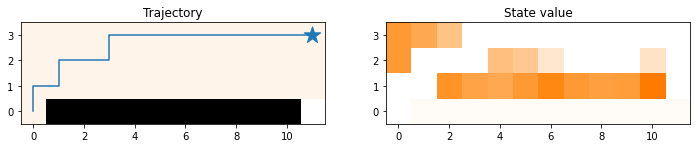

In [ ]:
# Setup environment
env = gridworld()                      
i0 = 0         
nTimestepsTrain = 5000                       # Number of timesteps
nTimestepsTest = 100                       # Number of timesteps
Shistory = np.zeros([2,nTimesteps+1])  # History of positions
Shistory[:,i0] = env.S                 # Initial position

# Actor-critic learning variables
V = np.zeros([12,4])         # Array of values (initialized to zero) for each state
theta = np.zeros([4,12,4])   # Array of propensities for each action (0,1,2,3) in each state     
delta = 0                    # Prediction error for current state
eta_v = 0.2                  # Value learning rate
eta_p = 0.1                 # Policy learning rate

# Actor's policy in any given state
def policy(theta_s_t):
  p_action = np.exp(theta_s_t)
  p_action = p_action/np.sum(p_action)
  action = np.where(np.random.multinomial(1,p_action)==1)[0][0]
  return action

#-----------------TRAINING-----------------------------

# Loop through timesteps to learn action values (without plotting)
for i in np.arange(1, nTimestepsTrain):
  clear_output(wait=True)
  # Move according to actor's policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  action = policy(theta[:,env.S[0],env.S[1]])
  Sprev, Scurr, Rcurr = env.move(action)

  # Temporal difference prediction error at current state
  delta = Rcurr + V[Scurr[0],Scurr[1]]-V[Sprev[0],Sprev[1]]

  # ***INSERT CRITIC LEARNING RULE HERE***
  V[Sprev[0],Sprev[1]] = V[Sprev[0],Sprev[1]] + eta_v*delta 

  # ***INSERT ACTOR LEARNING RULE HERE***
  theta[action,Sprev[0],Sprev[1]] = theta[action,Sprev[0],Sprev[1]] + eta_v*delta 

#-----------------TEST-----------------------------
env.S = [0,0]
# Simulate & plot actions for a few more timesteps (without learning any further)
for i in np.arange(1, nTimestepsTest):
  clear_output(wait=True)
  # Move according to actor's policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  action = policy(theta[:,env.S[0],env.S[1]])
  Sprev, Scurr, Rcurr = env.move(action)
  
  # Plot new position
  fig = plt.figure(figsize=(12, 4))
  ax1 = fig.add_subplot(121)
  env.plot(ax1)

  # Plot new value
  ax2 = fig.add_subplot(122)
  ax2.imshow(V.T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax2.invert_yaxis()
  ax2.set_title('State value')

  # Save new position
  Shistory[:,i] = Scurr
  # Plot most recent trajectory
  ax1.plot(Shistory[0,i0:i+1],Shistory[1,i0:i+1])
  ax1.set_title('Trajectory')
  if Scurr == [0,0]:
    i0 = i
  plt.show()

## 2. Q learning
The second algorithm we will use is Q-learning, which is an **action value learning** algorithm, since it learns values of actions in each state, and has a policy that needs to decide whether to exploit (pick the action with the highest action value) or explore (pick randomly in order to gain more information). The action values $Q(a_t, S_t)$ are updated using a temporal difference error that is computed using the currently chosen action $a_t$, and under the assumption that the agent will pick **optimally** in the future - hence involving a **max-operator** over possible future actions $a_{t+1}$. 

$$ \delta_{t+1} = r(S_{t+1}) + max_a(Q(a_{t+1},S_{t+1})) - Q(a_t , S_{t})\\
Q(a_t, S_{t})^{new} \leftarrow Q(a_t, S_t) + \eta \delta_{t+1}\\
$$


 ## Question 2
Add code below to calculate the prediction error according to Q-learning

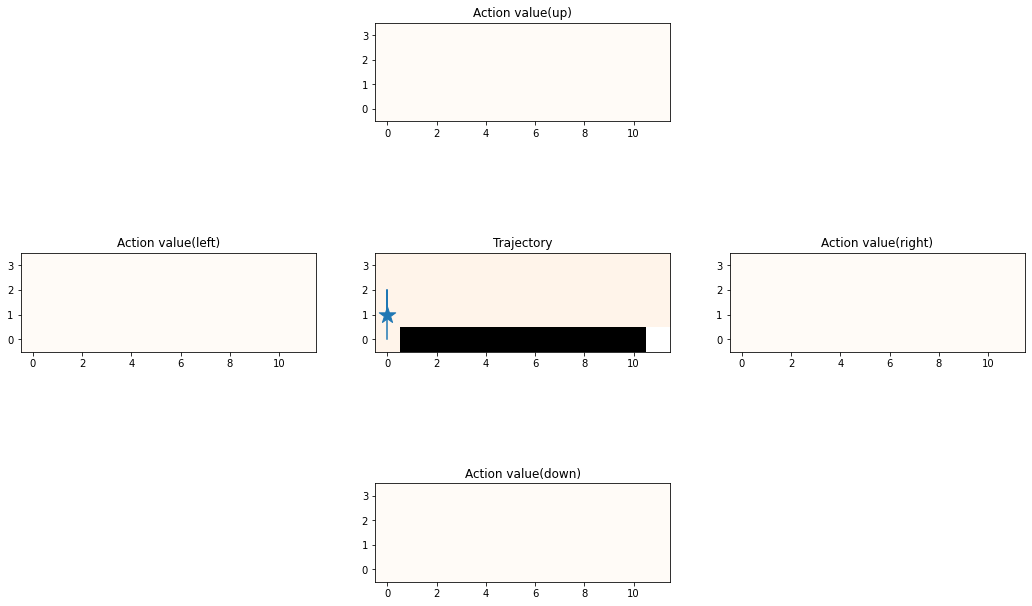

In [4]:
# Setup environment
env = gridworld()                      
i0 = 0         
nTimestepsTrain = 10000                    # Number of timesteps
nTimestepsTest = 50                        # Number of timesteps
Shistory = np.zeros([2,nTimestepsTest+1])  # History of positions
Shistory[:,i0] = env.S                     # Initial position

# Q-learning variables
Q = np.zeros([4,12,4])      # Array of action values for each action (0,1,2,3) in each state
delta = 0                   # Prediction error for current state
eta = 0.1                   # Learning rate
epsilon = 0.1               # Exploration rate

# Epsilon-greedy policy based on action values in any given state
def policy_epsilon(Q_s_t, epsilon):
  if np.random.rand()<epsilon:
    action = np.random.choice([0,1,2,3])           # Explore (i.e. random action) with probability epsilon
  else:
    action = np.where(Q_s_t==np.max(Q_s_t))[0][0]  # Exploit (i.e. highest value action) with probability 1-epsilon
  return action

#-----------------TRAINING-----------------------------

# Loop through timesteps to learn action values (without plotting)
for i in np.arange(1, nTimestepsTrain):

  # Move according to epsilon-greedy policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  actionPrev = policy_epsilon(Q[:,env.S[0],env.S[1]],epsilon)
  Sprev, Scurr, Rcurr = env.move(actionPrev)



  # ** INSERT Q-LEARNING PREDICTION ERROR HERE*
  delta


  # ** INSERT ACTION VALUE UPDATE EQUATION HERE*




#-----------------TEST-----------------------------

env.S = [0,0]
# Simulate & plot actions for a few more timesteps (without learning any further)
for i in np.arange(1, nTimestepsTest):
  clear_output(wait=True)
  # Move according to epsilon-greedy policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  actionPrev = policy_epsilon(Q[:,env.S[0],env.S[1]],epsilon)
  Sprev, Scurr, Rcurr = env.move(actionPrev)

  # Plot new position
  fig = plt.figure(figsize=(18, 12))
  ax1 = fig.add_subplot(335)
  env.plot(ax1)

  # Plot new action values
  ax2 = fig.add_subplot(334)
  ax2.imshow(Q[0,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax2.invert_yaxis()
  ax2.set_title('Action value(left)')
  ax3 = fig.add_subplot(336)
  ax3.imshow(Q[1,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax3.invert_yaxis()
  ax3.set_title('Action value(right)')
  ax4 = fig.add_subplot(338)
  ax4.imshow(Q[2,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax4.invert_yaxis()
  ax4.set_title('Action value(down)')
  ax5 = fig.add_subplot(332)
  ax5.imshow(Q[3,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax5.invert_yaxis()
  ax5.set_title('Action value(up)')

  # Save new position
  Shistory[:,i] = Scurr
  # Plot most recent trajectory
  ax1.plot(Shistory[0,i0:i+1],Shistory[1,i0:i+1])
  ax1.set_title('Trajectory')
  if Scurr == [0,0]:
    i0 = i
  plt.show()

### Question 2: Solution

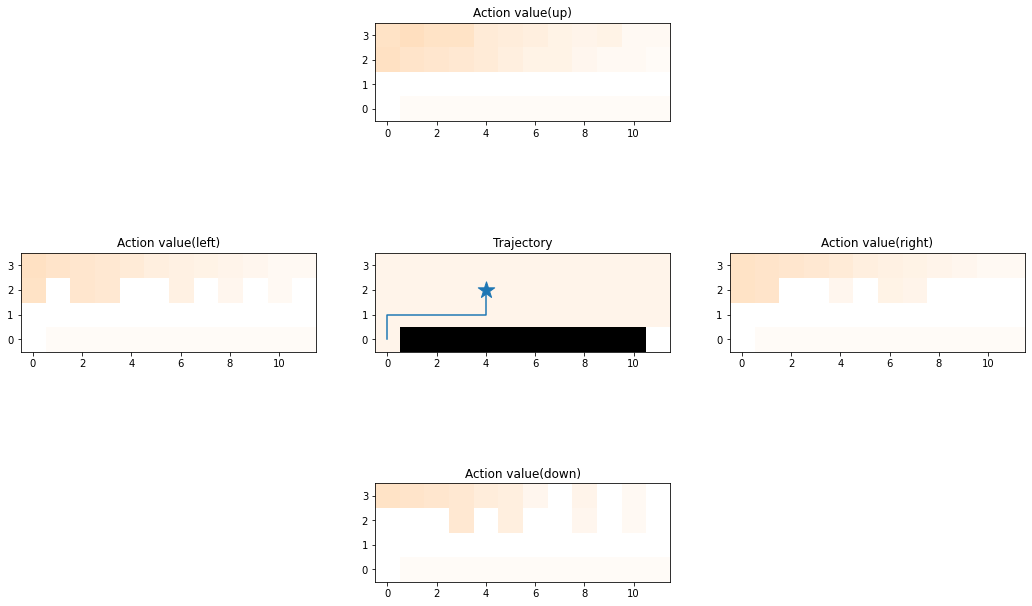

In [6]:
# Setup environment
env = gridworld()                      
i0 = 0         
nTimestepsTrain = 10000                        # Number of timesteps
nTimestepsTest = 20                        # Number of timesteps
Shistory = np.zeros([2,nTimestepsTest+1])  # History of positions
Shistory[:,i0] = env.S                 # Initial position

# Q-learning variables
Q = np.zeros([4,12,4])     # Array of action values for each action (0,1,2,3) in each state
delta = 0                   # Prediction error for current state
eta = 0.1                   # Learning rate
epsilon = 0.1               # Exploration rate

# Epsilon-greedy policy based on action values in any given state
def policy_epsilon(Q_s_t, epsilon):
  if np.random.rand()<epsilon:
    action = np.random.choice([0,1,2,3])
  else:
    action = np.where(Q_s_t==np.max(Q_s_t))[0][0]
  return action

#-----------------TRAINING-----------------------------

# Loop through timesteps to learn action values (without plotting)
for i in np.arange(1, nTimestepsTrain):
  # Move according to epsilon-greedy policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  actionPrev = policy_epsilon(Q[:,env.S[0],env.S[1]],epsilon)
  Sprev, Scurr, Rcurr = env.move(actionPrev)

  # ** INSERT Q-LEARNING PREDICTION ERROR HERE*
  delta = Rcurr + np.max(Q[:,Scurr[0],Scurr[1]])-Q[actionPrev,Sprev[0],Sprev[1]]

  # Action value update rule
  Q[actionPrev,Sprev[0],Sprev[1]] = Q[actionPrev,Sprev[0],Sprev[1]] + eta*delta 


#-----------------TEST-----------------------------

env.S = [0,0]
# Simulate & plot actions for a few more timesteps (without learning any further)
for i in np.arange(1, nTimestepsTest):
  clear_output(wait=True)
  # Move according to epsilon-greedy policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  actionPrev = policy_epsilon(Q[:,env.S[0],env.S[1]],epsilon)
  Sprev, Scurr, Rcurr = env.move(actionPrev)

  # Plot new position
  fig = plt.figure(figsize=(18, 12))
  ax1 = fig.add_subplot(335)
  env.plot(ax1)

  # Plot new action values
  ax2 = fig.add_subplot(334)
  ax2.imshow(Q[0,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax2.invert_yaxis()
  ax2.set_title('Action value(left)')
  ax3 = fig.add_subplot(336)
  ax3.imshow(Q[1,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax3.invert_yaxis()
  ax3.set_title('Action value(right)')
  ax4 = fig.add_subplot(338)
  ax4.imshow(Q[2,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax4.invert_yaxis()
  ax4.set_title('Action value(down)')
  ax5 = fig.add_subplot(332)
  ax5.imshow(Q[3,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax5.invert_yaxis()
  ax5.set_title('Action value(up)')

  # Save new position
  Shistory[:,i] = Scurr
  # Plot most recent trajectory
  ax1.plot(Shistory[0,i0:i+1],Shistory[1,i0:i+1])
  ax1.set_title('Trajectory')
  if Scurr == [0,0]:
    i0 = i
  plt.show()

## 3. SARSA
The third algorithm we will use is SARSA, which is also an **action value learning** algorithm. The main difference from Q-learning, is that in SARSA, action values $Q(a_t, S_t)$ are updated using a temporal difference error that is computed using the chosen action at the current timestep $a_t$, *and the action actually chosen at the future timestep* $a_{t+1}$. For this reason, SARSA is called **on-policy** because it evaluates actions based on the **actual future policy** of the agent, rather than assuming an optimal policy like Q-learning, which is called *off-policy* because its future policy may be different from the one that is used to evaluate prediction errors.

$$ \delta_{t+1} = r(S_{t+1}) + Q(a_{t+1},S_{t+1}) - Q(a_t , S_{t})\\
Q(a_t, S_{t})^{new} \leftarrow Q(a_t, S_t) + \eta \delta_{t+1}\\
$$


 ## Question 3
 Add code below to calculate the prediction error according to SARSA. Remember that you can only update $Q(S_t)$ *after* taking the action $a_{t+1}$. 

In [ ]:
# Setup environment
env = gridworld()                      
i0 = 0         
nTimestepsTrain = 10000                    # Number of timesteps
nTimestepsTest = 50                        # Number of timesteps
Shistory = np.zeros([2,nTimestepsTest+1])  # History of positions
Shistory[:,i0] = env.S                     # Initial position

# SARSA variables
Q = np.zeros([4,12,4])      # Array of action values for each action (0,1,2,3) in each state
delta = 0                   # Prediction error for current state
eta = 0.1                   # Learning rate
epsilon = 0.1               # Exploration rate

# Epsilon-greedy policy based on action values in any given state
def policy_epsilon(Q_s_t, epsilon):
  if np.random.rand()<epsilon:
    action = np.random.choice([0,1,2,3])           # Explore (i.e. random action) with probability epsilon
  else:
    action = np.where(Q_s_t==np.max(Q_s_t))[0][0]  # Exploit (i.e. highest value action) with probability 1-epsilon
  return action

#-----------------TRAINING-----------------------------

# Loop through timesteps to learn action values (without plotting)
for i in np.arange(1, nTimestepsTrain):
  # Decide future action according to epsilon-greedy policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  actionCurr = policy_epsilon(Q[:,env.S[0],env.S[1]],epsilon)

  if i>=2:

    # ** INSERT SARSA PREDICTION ERROR HERE*
    


    # ** INSERT ACTION VALUE UPDATE EQUATION HERE*



  # Move based on decided action - Possible actions are 0(left), 1(right), 2(down), 3(up)
  actionPrev = actionCurr
  Sprev, Scurr, Rcurr = env.move(actionPrev)


#-----------------TEST-----------------------------

env.S = [0,0]
# Simulate & plot actions for a few more timesteps (without learning any further)
for i in np.arange(1, nTimestepsTest):
  clear_output(wait=True)
  # Move according to epsilon-greedy policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  actionPrev = policy_epsilon(Q[:,env.S[0],env.S[1]],epsilon)
  Sprev, Scurr, Rcurr = env.move(actionPrev)

  # Plot new position
  fig = plt.figure(figsize=(18, 12))
  ax1 = fig.add_subplot(335)
  env.plot(ax1)

  # Plot new action values
  ax2 = fig.add_subplot(334)
  ax2.imshow(Q[0,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax2.invert_yaxis()
  ax2.set_title('Action value(left)')
  ax3 = fig.add_subplot(336)
  ax3.imshow(Q[1,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax3.invert_yaxis()
  ax3.set_title('Action value(right)')
  ax4 = fig.add_subplot(338)
  ax4.imshow(Q[2,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax4.invert_yaxis()
  ax4.set_title('Action value(down)')
  ax5 = fig.add_subplot(332)
  ax5.imshow(Q[3,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax5.invert_yaxis()
  ax5.set_title('Action value(up)')

  # Save new position
  Shistory[:,i] = Scurr
  # Plot most recent trajectory
  ax1.plot(Shistory[0,i0:i+1],Shistory[1,i0:i+1])
  ax1.set_title('Trajectory')
  if Scurr == [0,0]:
    i0 = i
  plt.show()

### Question 3: Solution

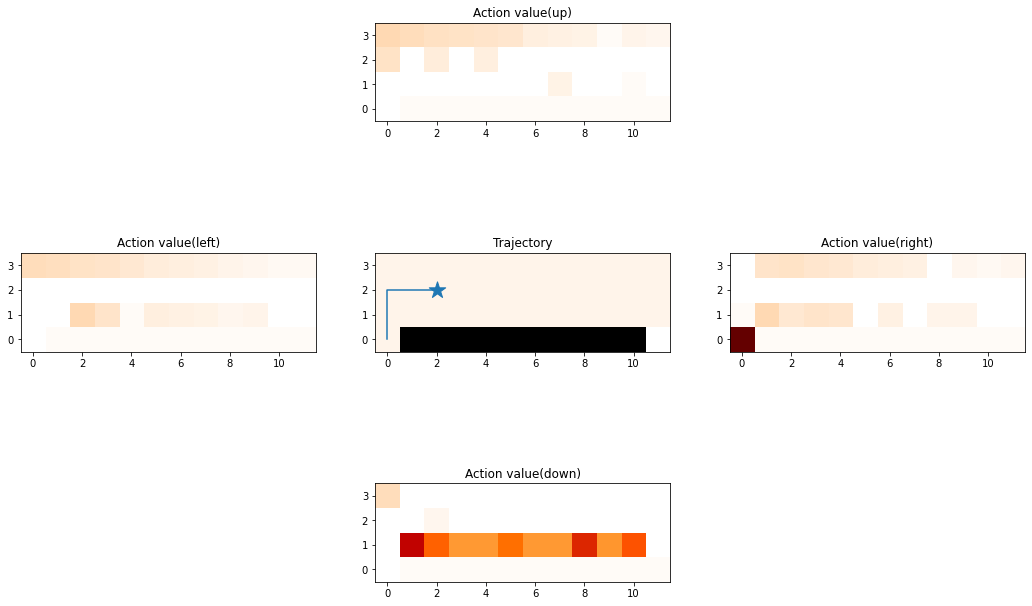

In [ ]:
# Setup environment
env = gridworld()                      
i0 = 0         
nTimestepsTrain = 10000                        # Number of timesteps
nTimestepsTest = 20                        # Number of timesteps
Shistory = np.zeros([2,nTimestepsTest+1])  # History of positions
Shistory[:,i0] = env.S                 # Initial position

# SARSA variables
Q = np.zeros([4,12,4])      # Array of action values for each action (0,1,2,3) in each state
delta = 0                   # Prediction error for current state
eta = 0.1                   # Learning rate
epsilon = 0.1               # Exploration rate

# Epsilon-greedy policy based on action values in any given state
def policy_epsilon(Q_s_t, epsilon):
  if np.random.rand()<epsilon:
    action = np.random.choice([0,1,2,3])
  else:
    action = np.where(Q_s_t==np.max(Q_s_t))[0][0]
  return action

#-----------------TRAINING-----------------------------

# Loop through timesteps to learn action values (without plotting)
for i in np.arange(1, nTimestepsTrain):
  # Decide future action according to softmax policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  actionCurr = policy_epsilon(Q[:,env.S[0],env.S[1]],epsilon)

  if i>1:
    # ** INSERT SARSA PREDICTION ERROR HERE*
    delta = Rcurr + Q[actionCurr,Scurr[0],Scurr[1]]-Q[actionPrev,Sprev[0],Sprev[1]]

    # Action value update rule
    Q[actionPrev,Sprev[0],Sprev[1]] = Q[actionPrev,Sprev[0],Sprev[1]] + eta*delta 

  # Move based on decided action - Possible actions are 0(left), 1(right), 2(down), 3(up)
  actionPrev = actionCurr
  Sprev, Scurr, Rcurr = env.move(actionPrev)


#-----------------TEST-----------------------------

env.S = [0,0]
# Simulate & plot actions for a few more timesteps (without learning any further)
for i in np.arange(1, nTimestepsTest):
  clear_output(wait=True)
  # Move according to softmax policy - Possible actions are 0(left), 1(right), 2(down), 3(up)
  actionPrev = policy_epsilon(Q[:,env.S[0],env.S[1]],epsilon)
  Sprev, Scurr, Rcurr = env.move(actionPrev)

  # Plot new position
  fig = plt.figure(figsize=(18, 12))
  ax1 = fig.add_subplot(335)
  env.plot(ax1)

  # Plot new action values
  ax2 = fig.add_subplot(334)
  ax2.imshow(Q[0,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax2.invert_yaxis()
  ax2.set_title('Action value(left)')
  ax3 = fig.add_subplot(336)
  ax3.imshow(Q[1,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax3.invert_yaxis()
  ax3.set_title('Action value(right)')
  ax4 = fig.add_subplot(338)
  ax4.imshow(Q[2,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax4.invert_yaxis()
  ax4.set_title('Action value(down)')
  ax5 = fig.add_subplot(332)
  ax5.imshow(Q[3,:,:].T,cmap=plt.cm.get_cmap('gist_heat'),vmin = -100, vmax = 1)
  ax5.invert_yaxis()
  ax5.set_title('Action value(up)')

  # Save new position
  Shistory[:,i] = Scurr
  # Plot most recent trajectory
  ax1.plot(Shistory[0,i0:i+1],Shistory[1,i0:i+1])
  ax1.set_title('Trajectory')
  if Scurr == [0,0]:
    i0 = i
  plt.show()

 ## Question 4
What is the difference between the policies learnt by on-policy vs off-policy learning? What do you think are the advantages/drawbacks to on-policy learning?

### Question 4: Solution


**Because Q-learning is off-policy, it assumes a different (optimal i.e. greedy) future policy for evaluation than the one it actually executes ($\epsilon$-greedy). Hence it learns to walk close to the cliff assuming it will never choose the non-greedy action of walking off the edge. This has the advantage of being the shortest path, but the disadvantage of occasionally falling off due to noise in its actual policy!**

**On the other hand SARSA is on-policy, so its evaluation takes into account the actual actions chosen. Hence it learns to stay away from the edge of the cliff, because it knows that it occasionally takes non-greedy actions. This has the disadvantage of being a longer path, but the advantage of avoiding falling off the cliff after learning!**



## Question 5
Suppose the agent had a close-to-greedy policy (i.e. epsilon ~0) but the gridworld was "windy" i.e. there was some probability that it could be carried away by the wind to an adjacent square at random at every step - which algorithm (SARSA vs Q-learning) would be preferable?


### Question 5: Solution

**The on-policy algorithm i.e. SARSA would be preferable, because environmental noise has a similar influence on the agent's efficacy as the internal policy noise parameter $\epsilon$ - meaning that the agent occasionally lands up in a random spot, not the one intended by the greedy policy.**


## Bonus question
Based on your answers to Q4 & Q5, under what conditions do you think an agent might develop anxious behavior? Check out http://www.princeton.edu/~ndaw/zmd20 for some answers...